# Exploratory Data Analysis

This notebok represent data anlysis for this kaggle competition: https://www.kaggle.com/competitions/spaceship-titanic/overview.

The methods were inspired and modified from this notebook: https://www.kaggle.com/code/gusthema/spaceship-titanic-with-tfdf.

The processing and analysis of the data will be done step by step with visualization after each step for better understanding.
However, after each series of steps we will summarize it into a function that we are going to use befor training.

## Imports

We will start with the imports that we are going to use in this notebook

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copy
import math

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb

# Data analyzing and processing

## Dataset

This paths will need to be changed according to your files location.
We are loading label and unlabeled data separately.

In [2]:
# loading dataset
data_df = pd.read_csv("C:/Users/chimi/OneDrive/Desktop/Tremend/train.csv")
test_df = pd.read_csv("C:/Users/chimi/OneDrive/Desktop/Tremend/test.csv")

## Check missing

Let's check if we have any missing values in the dataset.
We can see that there are a lot of missing values in both labeled and unlabeled data. We will have to fix that.

In [3]:
data_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

In [4]:
test_df.isnull().sum().sort_values(ascending=False)

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64

## Group features

Before dealing with missing values, we will remove unnecessary and group some features.

We will get rid of the Name feature as it's not really relevant for this task. It could eventually tell as if 2 people are relatives or not, but this might be just a coincidence. As well, 2 people might be relatives and still have different family names (eg. marriage). We also think that it's more important to know how is that person travelling with, and we already have this information.

In [5]:
data_df = data_df.drop(['Name'], axis=1)
data_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


The Cabin feature is bassicaly compossed by 3 features, so we will split it to be easier to process it.

In [6]:
# create the new colomns form the initial feature
data_df[["Deck", "Cabin_num", "Side"]] = data_df["Cabin"].str.split("/", expand=True)
# remove the initial feature
try:
    data_df = data_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")
data_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


We will to the same for PassengerId.

In [7]:
data_df[["Group", "Passenger"]] = data_df["PassengerId"].str.split("_", expand=True)
try:
    data_df = data_df.drop('PassengerId', axis=1)
except KeyError:
    print("Field does not exist")
data_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,Group,Passenger
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,0001,01
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,0002,01
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,0003,01
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,0003,02
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,0004,01


We can summarize this steps into one function.

Keep_id will be used to keep the PassengerId that will be needed for the submission of predictions.

In [8]:
def group_features(data_df, keep_id = False):
    data_df[["Deck", "Cabin_num", "Side"]] = data_df["Cabin"].str.split("/", expand=True)
    data_df[["Group", "Passenger"]] = data_df["PassengerId"].str.split("_", expand=True)
    to_drop = ['Name', 'Cabin']
    if keep_id == False:
        to_drop.append('PassengerId')
    try:
        data_df = data_df.drop(to_drop, axis=1)
    except KeyError:
        print("Field does not exist")
    return data_df

## Processing data

We have to convert categorical data into numerical data in order to be able to train them.
Let's take a look of the discret values that we have.

In [9]:
data_df['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [10]:
data_df['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [11]:
data_df['Deck'].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [12]:
data_df['Side'].unique()

array(['P', 'S', nan], dtype=object)

We can give a label (a number) for each unique value.
Eg: B -> 0, F -> 1, A -> 2 etc 

In [13]:
# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# Make mask for missing values
mask_planet = data_df['HomePlanet'].notna()
mask_destination = data_df['Destination'].notna()
mask_deck = data_df['Deck'].notna()
mask_side = data_df['Side'].notna()
mask_vip = data_df['VIP'].notna()
mask_cryo = data_df['CryoSleep'].notna()
mask_cabin = data_df['Cabin_num'].notna()
mask_group = data_df['Group'].notna()
mask_passenger = data_df['Passenger'].notna()

# Apply label encoder to the masked values
data_df.loc[mask_planet, 'HomePlanet'] = label_encoder.fit_transform(data_df.loc[mask_planet, 'HomePlanet']).astype(int)
data_df.loc[mask_destination, 'Destination'] = label_encoder.fit_transform(data_df.loc[mask_destination, 'Destination']).astype(int)
data_df.loc[mask_deck, 'Deck'] = label_encoder.fit_transform(data_df.loc[mask_deck, 'Deck']).astype(int)
data_df.loc[mask_side, 'Side'] = label_encoder.fit_transform(data_df.loc[mask_side, 'Side']).astype(int)
data_df.loc[mask_vip, 'VIP'] = data_df.loc[mask_vip, 'VIP'].astype(int)
data_df.loc[mask_cryo, 'CryoSleep'] = data_df.loc[mask_cryo, 'CryoSleep'].astype(int)
data_df.loc[mask_cabin, 'Cabin_num'] = data_df.loc[mask_cabin, 'Cabin_num'].astype(int)
data_df.loc[mask_group, 'Group'] = data_df.loc[mask_group, 'Group'].astype(int)
data_df.loc[mask_passenger, 'Passenger'] = data_df.loc[mask_passenger, 'Passenger'].astype(int)

C:\Users\chimi\AppData\Local\Temp\ipykernel_6316\2518781880.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_df.loc[mask_group, 'Group'] = data_df.loc[mask_group, 'Group'].astype(int)
C:\Users\chimi\AppData\Local\Temp\ipykernel_6316\2518781880.py:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_df.loc[mask_passenger, 'Passenger'] = data_df.loc[mask_passenger, 'Passenger'].astype(int)


In [14]:
data_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,Group,Passenger
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False,1,0,0,1,1
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True,5,0,1,2,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,0,0,1,3,1
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,0,0,1,3,2
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True,5,1,1,4,1


In [15]:
def preprocessing_data(data_df, test=False, fill=True):
    
    # Initialize label encoder
    label_encoder = preprocessing.LabelEncoder()

    if fill:

        # Make mask for missing values
        mask_planet = data_df['HomePlanet'].notna()
        mask_destination = data_df['Destination'].notna()
        mask_deck = data_df['Deck'].notna()
        mask_side = data_df['Side'].notna()

        # Apply label encoder to selected rows
        data_df.loc[mask_planet, 'HomePlanet'] = label_encoder.fit_transform(data_df.loc[mask_planet, 'HomePlanet']).astype(int)
        data_df.loc[mask_destination, 'Destination'] = label_encoder.fit_transform(data_df.loc[mask_destination, 'Destination']).astype(int)
        data_df.loc[mask_deck, 'Deck'] = label_encoder.fit_transform(data_df.loc[mask_deck, 'Deck']).astype(int)
        data_df.loc[mask_side, 'Side'] = label_encoder.fit_transform(data_df.loc[mask_side, 'Side']).astype(int)
 
    else:
        data_df['HomePlanet'] = label_encoder.fit_transform(data_df['HomePlanet']).astype(int)
        data_df['Destination'] = label_encoder.fit_transform(data_df['Destination']).astype(int)
        data_df['Deck'] = label_encoder.fit_transform(data_df['Deck']).astype(int)
        data_df['Side'] = label_encoder.fit_transform(data_df['Side']).astype(int)

    mask_vip = data_df['VIP'].notna()
    mask_cryo = data_df['CryoSleep'].notna()
    mask_cabin = data_df['Cabin_num'].notna()
    mask_group = data_df['Group'].notna()
    mask_passenger = data_df['Passenger'].notna()

    data_df.loc[mask_vip, 'VIP'] = data_df.loc[mask_vip, 'VIP'].astype(int)
    data_df.loc[mask_cryo, 'CryoSleep'] = data_df.loc[mask_cryo, 'CryoSleep'].astype(int)
    data_df.loc[mask_cabin, 'Cabin_num'] = data_df.loc[mask_cabin, 'Cabin_num'].astype(int)
    data_df.loc[mask_group, 'Group'] = data_df.loc[mask_group, 'Group'].astype(int)
    data_df.loc[mask_passenger, 'Passenger'] = data_df.loc[mask_passenger, 'Passenger'].astype(int)

    # We use this to convert the target value into 0 or 1 instead of False and True
    # However, in sklearn and pytorch this is not needed
    # if test == False:
    #     data_df['Transported'] = data_df['Transported'].astype(int)

    return data_df

We can use the following function to get rid of features that are not relevant for training.

In [16]:
def drop_features(data, features):
    try:
        data = data.drop(features, axis=1)
    except KeyError:
        print("Field does not exist")
    return data

## Deal with missing

One of the easiest way to deal with missing values is to remove the rows with missing values.


The advantage of this method is that it offers clear data.

However by doing this we will end up with a smaller dataset and this could hurt the trainig.

In [17]:
print("Number of rows before: ", len(data_df))

# drop rows with missing values
drop_data_df = data_df.dropna().copy()

print("Number of rows after: ", len(drop_data_df))

Number of rows before:  8693
Number of rows after:  6764


Other option is to fill the missing values.
Our first aproch is to fill any missing value with a special value: -1. 
The aim of this idea is that we hope that doing this way, a neural network will take advantage of nonlinearities and learn that this are spcial values and should not be used in the same way as other values.

In [18]:
fill_data_df = data_df.fillna(-1).copy()

# select rows with a value of -1
row_with_minus_one = fill_data_df.loc[fill_data_df['VIP'] == -1]
row_with_minus_one.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,Group,Passenger
38,0,0,0,15.0,-1,0.0,492.0,48.0,20.0,401.0,False,5,8,1,36,1
102,0,0,2,0.0,-1,0.0,0.0,0.0,0.0,0.0,True,6,19,1,108,3
145,2,1,2,35.0,-1,0.0,0.0,0.0,0.0,0.0,True,5,37,0,165,1
228,2,1,0,14.0,-1,0.0,0.0,0.0,0.0,0.0,True,5,47,1,244,2
566,2,0,2,-1.0,-1,43.0,152.0,182.0,1.0,2005.0,False,3,24,0,593,1


However, the approche of using a special value will definitely affect linear algorithms like SVM, KNN, Regresion etc. Also the effect on the neural netowrk might be not as wanted.

To avoide this we proposed filling continues values (like Age, ShoppingMall, Spa) with the mean of that column and discret values (like VIP, CryoSleep) with the most frequent values.

In [19]:
def missing(data_df, fill = True):
    if fill:
        # mode return a series of values orderd by frequency
        # we use iloc[0] to take the most frequent value
        data_df['CryoSleep'] =data_df['CryoSleep'].fillna(data_df['CryoSleep'].mode().iloc[0])
        data_df['ShoppingMall'] =data_df['ShoppingMall'].fillna(data_df['ShoppingMall'].mean())
        data_df['VIP'] =data_df['VIP'].fillna(data_df['VIP'].mode().iloc[0])
        data_df['HomePlanet'] =data_df['HomePlanet'].fillna(data_df['HomePlanet'].mode().iloc[0])
        data_df['Cabin_num'] =data_df['Cabin_num'].fillna(data_df['Cabin_num'].mode().iloc[0])
        data_df['VRDeck'] =data_df['VRDeck'].fillna(data_df['VRDeck'].mean())
        data_df['Deck'] =data_df['Deck'].fillna(data_df['Deck'].mode().iloc[0])
        data_df['Side'] =data_df['Side'].fillna(data_df['Side'].mode().iloc[0])
        data_df['FoodCourt'] =data_df['FoodCourt'].fillna(data_df['FoodCourt'].mean())
        data_df['Cabin_num'] =data_df['Cabin_num'].fillna(data_df['Cabin_num'].mode().iloc[0])
        data_df['Spa'] =data_df['Spa'].fillna(data_df['Spa'].mean())
        data_df['Destination'] =data_df['Destination'].fillna(data_df['Destination'].mode().iloc[0])
        data_df['RoomService'] =data_df['RoomService'].fillna(data_df['RoomService'].mean())
        data_df['Age'] =data_df['Age'].fillna(data_df['Age'].mean())
        return data_df
    else:
        return data_df.dropna().copy()

# Statistics

Let's see how many positive and negative data we have. As the data is balance we don't need to further warry about this.

<Axes: >

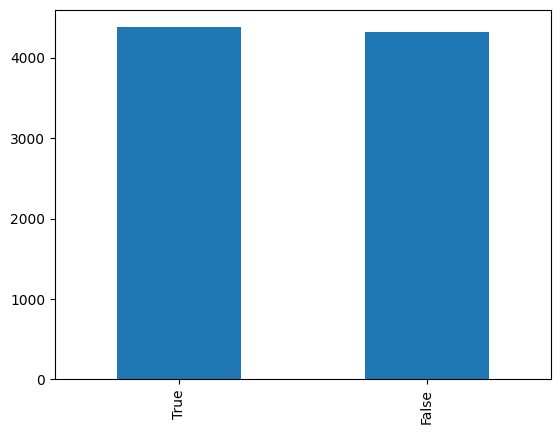

In [20]:
plot_df = fill_data_df.Transported.value_counts()
plot_df.plot(kind="bar")

Let's make a histogram for each feature to better understand the distribution that we are working with. Keep in mind that -1 means missing value.

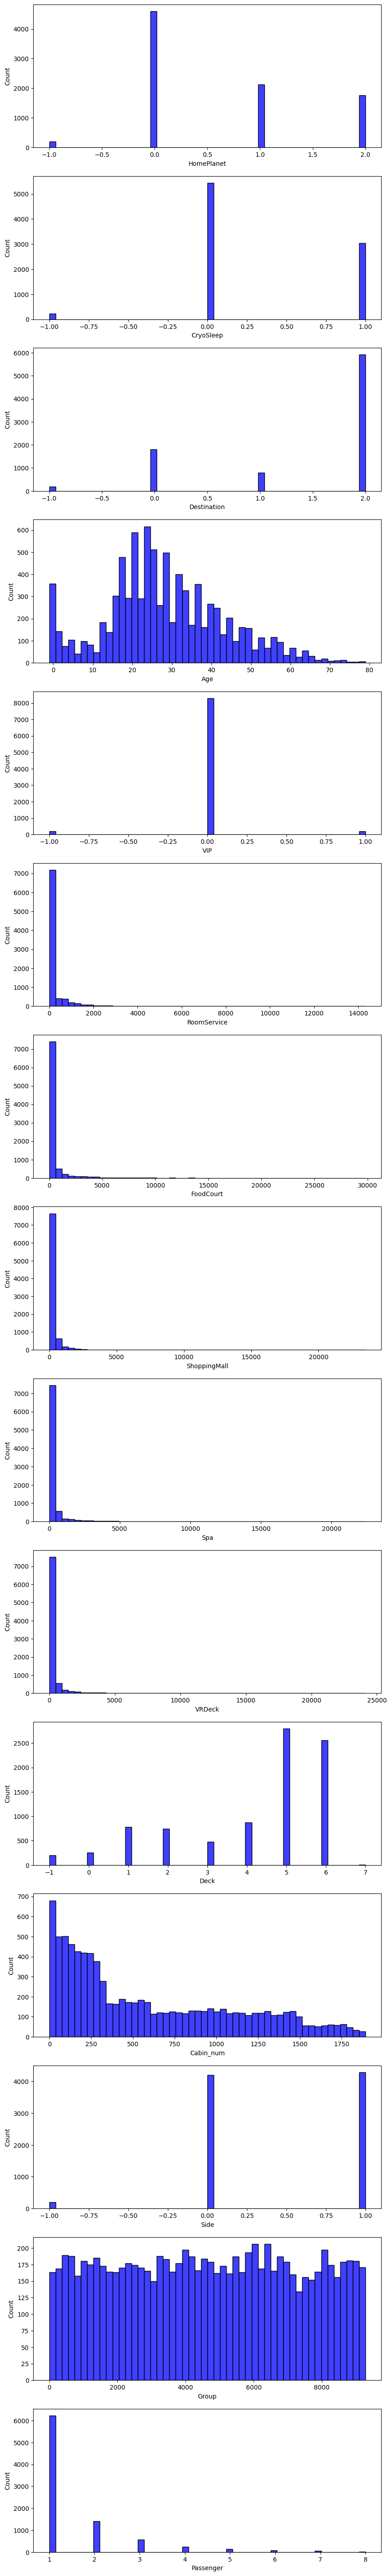

In [21]:
fig, ax = plt.subplots(len(fill_data_df.columns)-1, 1,  figsize=(10, 30))
plt.subplots_adjust(top = 2)


# loop through each feature
i = 0
for feature in fill_data_df.columns:
    # skip the target
    if feature == 'Transported':
        continue

    sns.histplot(fill_data_df[feature], color='blue', bins=50, ax=ax[i])
    
    ax[i].set_xlabel(feature)

    i += 1

plt.show()

We can indentify (similarities with) some well known distributions like: Normal - Age; Geometric - Passenger, Spa, ShoppingMall etc; Uniform - Group. We can also see that very few people have vip so it could be useless for training. It also worth to notice that we have a pretty big number of missing values for age.

As our task is to do binary classification we are quite interested to compare the values of positive rows agains the negative. We will modify the above code to do that.

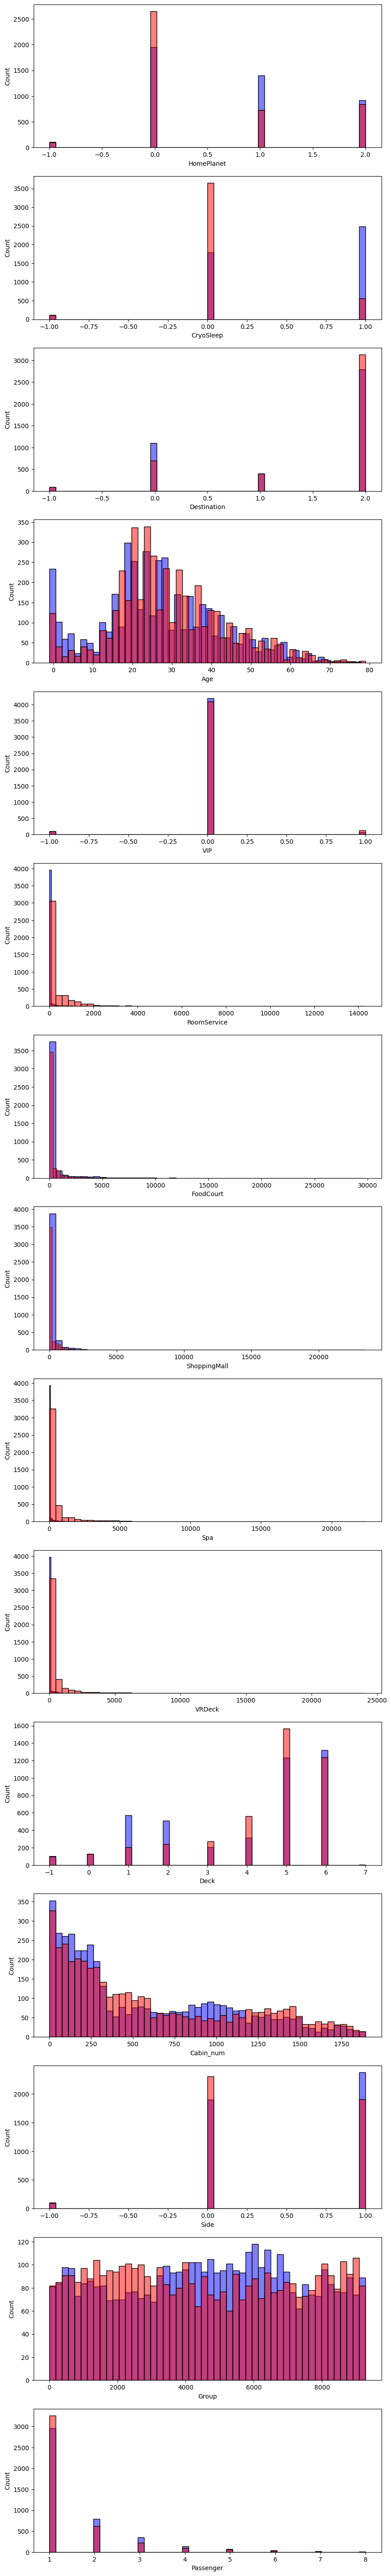

In [22]:
fig, ax = plt.subplots(len(fill_data_df.columns)-1, 1,  figsize=(10, 30))
plt.subplots_adjust(top = 2)

# loop through each feature
i = 0
for feature in fill_data_df.columns:
    # skip the target
    if feature == 'Transported':
        continue
    
    # create separate dataframes for positive and negative rows
    transported = fill_data_df[fill_data_df['Transported'] == 1][feature]
    not_transported = fill_data_df[fill_data_df['Transported'] == 0][feature]

    # plot histograms with different colors and 0.5 transparency
    sns.histplot(transported, color='blue', alpha=0.5, bins=50, ax=ax[i])
    sns.histplot(not_transported, color='red', alpha=0.5, bins=50, ax=ax[i])
    
    ax[i].set_xlabel(feature)

    i += 1

plt.show()


We can see that we have very similar distributions between positive and negative data. That might be a problem for models like SVM and Logistic Regression

We can visualise this distributions in terms of mean and standard deviation. Tha range of each feature is very different and if we leave it like that some features will have greater impact on training just because they have greater values, not necessary beacuse they are more important.

In [23]:
drop_data_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,Passenger
count,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000
mean,28.897398,224.415582,479.736251,180.495713,313.856298,304.565937,4657.930367,1.517002
std,14.529563,648.056361,1676.922138,638.032157,1138.989471,1126.895655,2671.837700,1.054836
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2355.250000,1.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4644.500000,1.000000
75%,38.000000,51.000000,82.000000,30.250000,66.250000,52.000000,6906.000000,2.000000
max,79.000000,9920.000000,29813.000000,23492.000000,22408.000000,20336.000000,9280.000000,8.000000


We will use standardization to fix this.
Doing so, we will end up with a Standard Normal Distribution (mean=0, std=1).

In [24]:
# create a StandardScaler object
scaler = StandardScaler()

# create a standardized copy of the DataFrame
standardized_df = drop_data_df.copy()

# extract the columns to be standardized
cols_to_standardize = drop_data_df.columns.difference(['Transported'])

# fit the scaler to the data
scaler.fit(drop_data_df[cols_to_standardize])
# standardize the selected columns
standardized_df[cols_to_standardize] = scaler.transform(drop_data_df[cols_to_standardize])

standardized_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,Group,Passenger
0,0.418941,-0.736806,0.633695,0.695365,-0.157634,-0.346316,-0.286103,-0.282915,-0.275577,-0.270290,False,-1.830531,-1.167283,-1.012796,-1.743098,-0.490162
1,-0.835472,-0.736806,0.633695,-0.337089,-0.157634,-0.178108,-0.280735,-0.243729,0.206465,-0.231242,True,0.401112,-1.167283,0.987365,-1.742724,-0.490162
2,0.418941,-0.736806,0.633695,2.003140,6.343808,-0.279959,1.846533,-0.282915,5.620436,-0.226804,False,-2.388441,-1.167283,0.987365,-1.742349,-0.490162
3,0.418941,-0.736806,0.633695,0.282383,-0.157634,-0.346316,0.479046,0.298603,2.647405,-0.099010,False,-2.388441,-1.167283,0.987365,-1.742349,0.457923
4,-0.835472,-0.736806,0.633695,-0.887732,-0.157634,0.121271,-0.244356,-0.046233,0.220513,-0.268515,True,0.401112,-1.165332,0.987365,-1.741975,-0.490162


In [25]:
standardized_df.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side,Group,Passenger
count,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03,6.764000e+03
mean,8.193722e-17,6.906887e-17,-8.403817e-17,-4.306956e-17,4.832195e-17,-2.100954e-18,1.050477e-17,6.302863e-18,-3.098908e-17,2.678717e-17,9.296723e-17,1.008458e-16,-6.565482e-17,6.723054e-17,1.208049e-16
std,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00
min,-8.354719e-01,-7.368061e-01,-1.798945e+00,-1.989016e+00,-1.576340e-01,-3.463158e-01,-2.861026e-01,-2.829153e-01,-2.755772e-01,-2.702898e-01,-2.388441e+00,-1.167283e+00,-1.012796e+00,-1.743098e+00,-4.901616e-01
25%,-8.354719e-01,-7.368061e-01,-5.826251e-01,-6.812407e-01,-1.576340e-01,-3.463158e-01,-2.861026e-01,-2.829153e-01,-2.755772e-01,-2.702898e-01,-7.147096e-01,-8.438871e-01,-1.012796e+00,-8.618976e-01,-4.901616e-01
50%,-8.354719e-01,-7.368061e-01,6.336947e-01,-1.305984e-01,-1.576340e-01,-3.463158e-01,-2.861026e-01,-2.829153e-01,-2.755772e-01,-2.702898e-01,4.011117e-01,-3.409890e-01,9.873654e-01,-5.027012e-03,-4.901616e-01
75%,4.189414e-01,1.357209e+00,6.336947e-01,6.265347e-01,-1.576340e-01,-2.676131e-01,-2.371998e-01,-2.355004e-01,-2.174073e-01,-2.241420e-01,9.590223e-01,7.721181e-01,9.873654e-01,8.414567e-01,4.579234e-01
max,1.673355e+00,1.357209e+00,6.336947e-01,3.448576e+00,6.343808e+00,1.496213e+01,1.749362e+01,3.653927e+01,1.939946e+01,1.777708e+01,1.516933e+00,2.528115e+00,9.873654e-01,1.730049e+00,6.146433e+00
